In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from env import get_db_url
import math
# Import acquire and prepare
import acquire
import wrangle

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Load currciculum access logs
df = acquire.get_access_data()

In [3]:
df, df_staff, df_multicohort, df_unimputed, df_non_curriculum, df_outliers = wrangle.full_wrangle()

This returned the following dataframes (reassign if you missed any):


,Description,Record Count,Percent of Raw df
Dataframe,,,
df,Fully cleaned dataframe,509409,56.6%
df_staff,Cohort == Staff,84031,9.33%
df_multicohort,Users listed in more than one cohort,22708,2.52%
df_unimputed,Users with unknown/unimputable cohorts,45904,5.1%
df_non_curriculum,"Accessess not related to the curriculum, i.e. directories, images",116539,12.9%
df_outliers,Accesses meeting outlier conditions,121626,13.5%


In [4]:
df.head()

,accessed,path,ip,user_id,program_id,program_type,cohort,start_date,end_date,lesson,hour
1,2018-01-26 09:56:02,java-ii,97.105.19.61,1,1.0,Web Development,Hampton,2015-09-22,2016-02-06,Not Lesson,9
2,2018-01-26 09:56:05,java-ii/object-oriented-programming,97.105.19.61,1,1.0,Web Development,Hampton,2015-09-22,2016-02-06,java-ii.object-oriented-programming,9
3,2018-01-26 09:56:06,slides/object_oriented_programming,97.105.19.61,1,1.0,Web Development,Hampton,2015-09-22,2016-02-06,slides.object_oriented_programming,9
4,2018-01-26 09:56:24,javascript-i/conditionals,97.105.19.61,2,2.0,Web Development,Teddy,2018-01-08,2018-05-17,javascript-i.conditionals,9
5,2018-01-26 09:56:41,javascript-i/loops,97.105.19.61,2,2.0,Web Development,Teddy,2018-01-08,2018-05-17,javascript-i.loops,9


In [5]:
df.program_type.value_counts()

Web Development    451039
Data Science        58370
Name: program_type, dtype: int64

In [6]:
df.dtypes

accessed        datetime64[ns]
path                    object
ip                      object
user_id                  int64
program_id             float64
program_type            object
cohort                  object
start_date      datetime64[ns]
end_date        datetime64[ns]
lesson                  object
hour                     int64
dtype: object

In [7]:
# Create seperate dataframes for Web Development and Data Science programs
wd = df[df.program_type != 'Data Science']
ds = df[df.program_type == 'Data Science']


# 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?

In [8]:
# Pages with most traffic
pd.DataFrame(wd.lesson.value_counts().head())

,lesson
Not Lesson,97362
mysql.tables,5477
javascript-i.introduction.working-with-data-types-operators-and-variables,5312
mysql.databases,5169
javascript-i.functions,5163


In [9]:
# Pages with most traffic
pd.DataFrame(ds.lesson.value_counts().head())

,lesson
classification.overview,1310
1-fundamentals.1.1-intro-to-data-science,1270
classification.scale_features_or_not.svg,1138
sql.mysql-overview,1008
fundamentals.intro-to-data-science,946


# 2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

plt.figure(figsize=(15,10))
wd[wd.path == 'javascript-i'].path.resample('Q').count().plot()
wd[wd.path == 'java-iii'].path.resample('Q').count().plot()
wd[wd.path == 'html-css'].path.resample('Q').count().plot()
wd[wd.path == 'java-ii'].path.resample('Q').count().plot()
wd[wd.path == 'spring'].path.resample('Q').count().plot()
plt.legend(labels = ['javascript-i', 'java-iii', 'html-css', 'java-ii', 'spring'])
plt.title('Most Trafficed Curriculum Webpages by Web Development Students Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Page Visits')

# 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

In [10]:
# Filter dataframe for the time when student were 'active' for each program
active_wd = wd.loc[(wd.accessed >= wd.start_date) & (wd.accessed <= wd.end_date)]
active_ds = ds.loc[(ds.accessed >= ds.start_date) & (ds.accessed <= ds.end_date)]

In [11]:
# web dev users with lowest page count
hardly_access_wd = active_wd.groupby('user_id').size().sort_values().head(20)
hardly_access_wd

user_id
278     3
340    13
963    15
41     22
371    24
529    29
967    30
978    32
36     36
57     42
543    43
56     44
45     51
46     51
975    59
969    60
65     63
33     63
250    63
253    71
dtype: int64

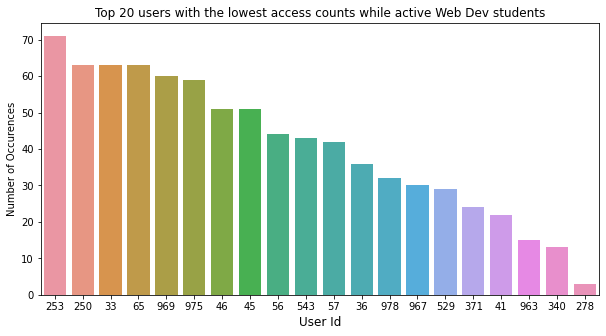

In [12]:
#histogram of these users under 20 logged access dates:
user_id_count = active_wd.groupby('user_id').size().sort_values()
user_id_count = user_id_count[:20]
my_order = list(hardly_access_wd.index)
my_order.reverse()
plt.figure(figsize=(10,5))
#plt.figure(figsize=(10,5))
sns.barplot(user_id_count.index, user_id_count.values, order=my_order)
plt.title ('Top 20 users with the lowest access counts while active Web Dev students')
plt.ylabel('Number of Occurences')
plt.xlabel('User Id', fontsize=12)
plt.show()

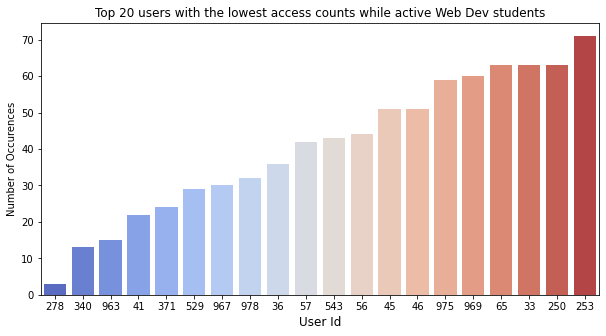

In [13]:
#histogram of these users under 20 logged access dates:
user_id_count = active_wd.groupby('user_id').size().sort_values()
user_id_count = user_id_count[:20]
#my_order = list(hardly_access_wd.index)
#my_order.reverse()
plt.figure(figsize=(10,5))
#plt.figure(figsize=(10,5))
sns.barplot(user_id_count.index, user_id_count.values, palette="coolwarm", order=hardly_access_wd.index)
plt.title ('Top 20 users with the lowest access counts while active Web Dev students')
plt.ylabel('Number of Occurences')
plt.xlabel('User Id', fontsize=12)
plt.show()

In [14]:
# data science users with lowest page count
hardly_access_ds = active_ds.groupby('user_id').size().sort_values().head()
hardly_access_ds

user_id
902    118
780    145
577    190
901    201
683    205
dtype: int64

# 4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?

In [15]:
# Requests allows you to send HTTP/1.1 requests extremely easily. There’s no need to manually add query 
# strings to your URLs, or to form-encode your PUT & POST data — but nowadays, just use the json method!

import requests

In [16]:
df_sus_users = df.copy()

ip_count = df_sus_users.ip.nunique()
ip_count

2560

In [17]:
#pd.set_option('display.max_rows', None)
#df_sus_users.groupby('ip').size().sort_values().unique()

In [18]:
df_sus_users.loc[df_sus_users['ip'] == '221.229.204.176']

,accessed,path,ip,user_id,program_id,program_type,cohort,start_date,end_date,lesson,hour


In [19]:
import ipapi

In [20]:
ipapi.location(ip='221.229.204.176')

{'ip': '221.229.204.176',
 'version': 'IPv4',
 'city': 'Tongshan',
 'region': 'Henan',
 'region_code': 'HA',
 'country': 'CN',
 'country_name': 'China',
 'country_code': 'CN',
 'country_code_iso3': 'CHN',
 'country_capital': 'Beijing',
 'country_tld': '.cn',
 'continent_code': 'AS',
 'in_eu': False,
 'postal': None,
 'latitude': 32.7705,
 'longitude': 113.561,
 'timezone': 'Asia/Shanghai',
 'utc_offset': '+0800',
 'country_calling_code': '+86',
 'currency': 'CNY',
 'currency_name': 'Yuan Renminbi',
 'languages': 'zh-CN,yue,wuu,dta,ug,za',
 'country_area': 9596960.0,
 'country_population': 1392730000,
 'asn': 'AS4134',
 'org': 'Chinanet'}

In [21]:
#pd.set_option('display.max_columns', None)

import json

# IP address to test
ip_address = '24.242.183.202'

# URL to send the request to
request_url = 'https://geolocation-db.com/jsonp/' + ip_address
# Send request and decode the result
response = requests.get(request_url)
result = response.content.decode()
# Clean the returned string so it just contains the dictionary data for the IP address
result = result.split("(")[1].strip(")")
# Convert this data into a dictionary
result  = json.loads(result)
print(result)

{'country_code': 'US', 'country_name': 'United States', 'city': 'Killeen', 'postal': '76541', 'latitude': 31.1164, 'longitude': -97.7278, 'IPv4': '24.242.183.202', 'state': 'Texas'}


In [22]:
import ipaddress 

def validate_ip_address(df_sus_users):
    try:
        ip = ipaddress.ip_address(df_sus_users.ip)
        print("IP address {} is valid. The object returned is {}".format(df_sus_users, ip))
    except ValueError:
        print("IP address {} is not valid".format(df_sus_users))

In [23]:
#validate_ip_address(df_sus_users)

# 5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

In [24]:
# Number of cross-accessed pages in the last year
df[2019:].groupby('path').size().index.isin(df[2019:].groupby('path').size().index).sum()

1484

In [25]:
# Unique pages in a list of WD and DS
wd_users = list(wd.user_id.unique())
ds_users = list(ds.user_id.unique())

In [26]:
# All cross accessed observations
cross_observations = df[2019:][(df[2019:].path.isin(wd[2019:].path)) & (df[2019:].path.isin(ds[2020:].path))]
cross_observations.head()

,accessed,path,ip,user_id,program_id,program_type,cohort,start_date,end_date,lesson,hour
2731,2018-01-31 13:55:18,mysql,97.105.19.61,33,2.0,Web Development,Sequoia,2017-09-27,2018-02-15,Not Lesson,13
2737,2018-01-31 13:56:50,html-css/forms,97.105.19.61,16,2.0,Web Development,Sequoia,2017-09-27,2018-02-15,html-css.forms,13
2744,2018-01-31 14:04:42,mysql,97.105.19.61,33,2.0,Web Development,Sequoia,2017-09-27,2018-02-15,Not Lesson,14
2763,2018-01-31 14:19:32,mysql,97.105.19.61,33,2.0,Web Development,Sequoia,2017-09-27,2018-02-15,Not Lesson,14
2778,2018-01-31 14:32:16,javascript-i,97.105.19.61,11,1.0,Web Development,Arches,2014-02-04,2014-04-22,Not Lesson,14


In [27]:
# Cohorts who cross accessed
cross_observations.cohort.value_counts()

Ceres         6384
Voyageurs     6344
Apex          6056
Zion          6041
Jupiter       5758
Xanadu        5662
Deimos        5630
Fortuna       5208
Teddy         4874
Hyperion      4722
Ganymede      4560
Bayes         4553
Kalypso       4003
Darden        3928
Andromeda     3904
Betelgeuse    3845
Curie         3581
Bash          3427
Europa        3408
Wrangell      3278
Ulysses       3170
Yosemite      2871
Lassen        2512
Marco         2307
Luna          2075
Sequoia       1587
Arches        1190
Easley        1021
Florence       787
Pinnacles      507
Neptune        360
Hampton        335
Niagara        230
Kings          147
Olympic        115
Quincy          99
Ike             90
Mammoth         75
Oberon          53
Franklin        20
Glacier         12
Joshua           8
Badlands         6
Name: cohort, dtype: int64

# 6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?

In [29]:
# Filters dataframes for program_types (web dev & data science) only after graduation date
grad_accessed_wd = wd[(wd.accessed > wd.end_date)]
grad_accessed_ds = ds[(ds.accessed > ds.end_date)]

In [30]:
# Returns the the top 5 lessons by web dev after graduation
grad_accessed_wd.lesson.value_counts()[1:6]

spring.fundamentals.controllers     959
spring.fundamentals.views           907
spring.setup                        892
spring.fundamentals.repositories    871
html-css.elements                   683
Name: lesson, dtype: int64

In [31]:
# Returns the top 5 lessons by data science after graduation
grad_accessed_ds.lesson.value_counts()[1:6]

sql.mysql-overview                          210
classification.scale_features_or_not.svg    174
fundamentals.intro-to-data-science          138
anomaly-detection.overview                  127
1-fundamentals.1.1-intro-to-data-science    117
Name: lesson, dtype: int64

Text(0.5, 1.0, 'Topics Referenced after Graduation Data Science')

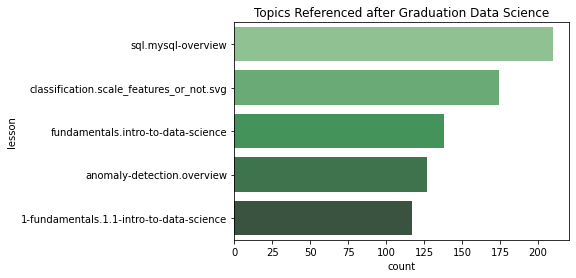

In [32]:
# plots the lessons on y-axis and counts on x-axis
sns.countplot(y="lesson", data=grad_accessed_ds, palette="Greens_d", 
              order=grad_accessed_ds.lesson.value_counts()[1:6].index)
plt.title("Topics Referenced after Graduation Data Science")

Text(0.5, 1.0, 'Topics Referenced after Graduation Web Development')

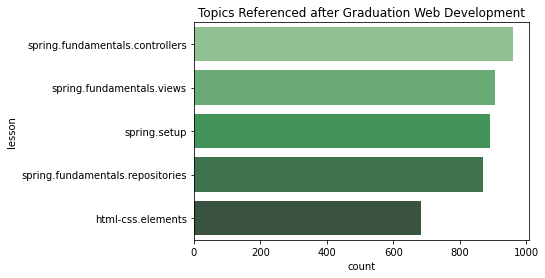

In [33]:
# plots the lessons on y-axis and counts on x-axis
sns.countplot(y="lesson", data=grad_accessed_wd, palette="Greens_d", 
              order=grad_accessed_wd.lesson.value_counts()[1:6].index)
plt.title("Topics Referenced after Graduation Web Development")

# 7. Which lessons are least accessed?

In [35]:
wd.path.value_counts().tail()

examples/css/..%5c    1
115                   1
133                   1
131                   1
javascript/loops      1
Name: path, dtype: int64

In [36]:
ds.path.value_counts().tail()

itc%20-%20ml                 1
itc-ml                       1
java-i/console-io            1
clustering/dbscan            1
2.1-spreadsheets-overview    1
Name: path, dtype: int64

In [37]:
df['is_active'] = (df.accessed >= df.start_date) & (df.accessed <= df.end_date)
df.head(2)


,accessed,path,ip,user_id,program_id,program_type,cohort,start_date,end_date,lesson,hour,is_active
1,2018-01-26 09:56:02,java-ii,97.105.19.61,1,1.0,Web Development,Hampton,2015-09-22,2016-02-06,Not Lesson,9,False
2,2018-01-26 09:56:05,java-ii/object-oriented-programming,97.105.19.61,1,1.0,Web Development,Hampton,2015-09-22,2016-02-06,java-ii.object-oriented-programming,9,False


In [38]:


Mth = sns.kdeplot(sample.accessed[(sample["is_active"] == False) ],
                color="#0072BD", shade = True)
Mth = sns.kdeplot(sample.accessed[(sample["is_active"] == True) ],
                ax =Mth, color="#ebb086", shade= True)
Mth.legend(["Is Active","Not Active"])
Mth.set_ylabel('Density')
Mth.set_xlabel('Accessed')
Mth.set_title('Monthly charges by churn')

NameError: name 'sample' is not defined

In [ ]:
def percentage_stacked_plot(columns_to_plot, title, df):
    
    '''
    Returns a 100% stacked plot of the response variable for independent variable of the list columns_to_plot.
    Parameters: columns_to_plot (list of string): Names of the variables to plot
    '''
    
    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)

    # create a figure
    fig = plt.figure(figsize=(12, 5 * number_of_rows)) 
    fig.suptitle(title, fontsize=22,  y=.95)
 

    # loop to each column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):

        # create the subplot
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)

        # calculate the percentage of observations of the response variable for each group of the independent variable
        # 100% stacked bar plot
        prop_by_independent = pd.crosstab(df[column], df['is_active']).apply(lambda x: x/x.sum()*100, axis=1)

        prop_by_independent.plot(kind='bar', ax=ax, stacked=True,
                                 rot=0, color=['#94bad4','#ebb086'])

        # set the legend in the upper right corner
        ax.legend(loc="upper right", bbox_to_anchor=(0.62, 0.5, 0.5, 0.5),
                  title='Active?', fancybox=True)

        # eliminate the frame from the plot
        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)

    return percentage_stacked_plot

In [ ]:
# type of internet service attributes
services_columns = ['program_type','program_id']

# stacked plot of internet service attributes
percentage_stacked_plot(services_columns, 'Program Types', df)

#0 means no they do not have this feature